<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">
     
Outlier Detection/Cleaning workflow
================

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">

The following notebook contains the process' that make up the Cleaning workflow. The notebook consists of: an imput process, selecting relevant columns, choosing the desired algorithm, and execution of the workflow. The algorithms that are available are: KMeans and Gaussian Mixture models.

__Note__: Spark has other clustering methods available, Bisecting KMeans and Latent Dirichlet Allocation which is used for topic modelling. These are not included in this workflow, due to unstability in these algorithms!




##### Initial imports and change the work directory to the base project folder.

In [1]:
%run -i initilization.py

/home/svanhmic/workspace/DABAI/Workflows


#####  Data importation 

This workflow uses our homemade class that handles importation of data.

In [2]:
from shared.Extension_to_timeit import pretty_time_result
from shared.GeneralDataImport import GeneralDataImport

dataIO = GeneralDataImport(parquet_path+"/normal_cluster_n_1000.parquet")

Widget Javascript not detected.  It may not be installed or enabled properly.


##### Select the relevant columns to be used in the imported dataset 

Select respectively columns assigned to be lables and columns that are features

In [4]:
dataIO.select_columns()

##### An initial look at the data
* Lets look at the raw numbers...
* We also have a plot showing how the data is distributed in 2D

In [5]:
df = dataIO.data_frame
df.limit(5).toPandas()

,id,k,dimension,a,b
0,0,1,2,5.681480,3.158786
1,1,1,2,2.984444,5.840077
2,2,1,2,4.563474,4.873891
3,3,1,2,5.353377,4.905738
4,4,1,2,3.980736,5.922937


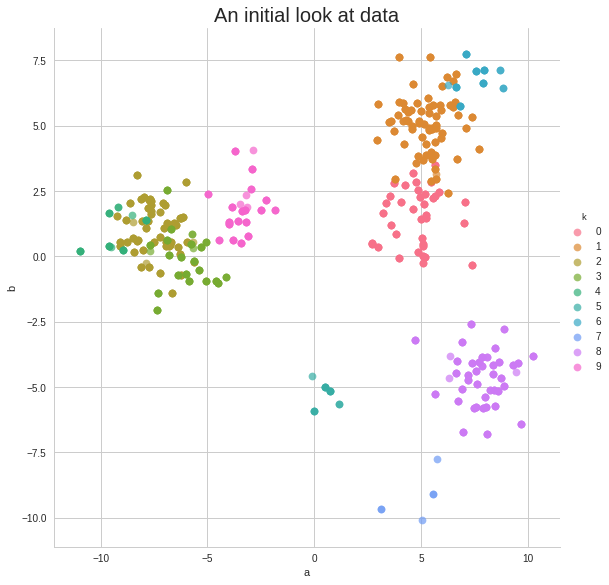

In [6]:
#ax = sb.regplot('a','b',df.toPandas(),fit_reg=False)
ax = sb.lmplot(
    'a',
    'b',
    dataIO.data_frame.toPandas(),
    fit_reg=False,
    size=8,
    hue='k',
    scatter_kws={'alpha':0.7,'s':60}
)
ax.ax.set_title('An initial look at data',fontsize=20)
plt.show()

In [7]:
#import data!
#from pyspark.sql import functions as F
#from shared.create_dummy_data import create_dummy_data 

#test_timer = %timeit -o feature_data = create_dummy_data(1000, "x y z", "label", outlier_number=0.2, outlier_factor=20)
#feature_data = feature_data.select([(10*F.col(i)).alias(i) for i in ["x","y","z"]])
#feature_data.orderBy('x',ascending=[0,0,0]).show()

###  Lets select an alogrithm for this test instance. 

__Note:__ We should also set some parameters; and this can be done via the fancy widgets.

In [8]:
# Select parameters
from cleaning.CreateParametersCleaning import ParamsCleaning

params = ParamsCleaning()
parameters = params.select_parameters()

In [9]:
parameters

__Just to verify that we have the correct algorithm and parameters__

In [10]:
#print(params.output_parameters(parameters))
#test_params_1 = {'tol': 0.00001, 'k': 3, 'maxIter': 300, 'algorithm': 'GaussianMixture', 'seed': 1080866016001745000}
test_params_1 = params.output_parameters(parameters)
print(test_params_1)

{'tol': 0.0001, 'initMode': 'k-means||', 'k': 2, 'seed': 7969353092125344463, 'algorithm': 'KMeans', 'maxIter': 20, 'initSteps': 5}


In [11]:
#print(sc.defaultMinPartitions)
#print(sc.defaultParallelism)
#conf = sc.getConf()
#conf.getAll()

### OK! So fare so good. 

Lets create the [pipeline](http://spark.apache.org/docs/2.0.0/ml-pipeline.html). We have all the ingredients needed to create it. 
Furthermore, we have some hacks! In order to performance test the algorithms properly, we have to import several datasets. This is ussually done below, but for this showcase we only use *df*

In [12]:
from cleaning.ExecuteCleaningWorkflow import ExecuteWorkflow

partitions = [80]
sizes = [1000]
features = list(map(
    lambda x: x.name,
    dataIO.list_features)
               )

labels = list(map(
    lambda x: x.name,
    dataIO.list_label)
             )

#print(features)
#print(labels)

execution_model = ExecuteWorkflow(
    dict_params = test_params_1,
    cols_features = features, 
    cols_labels = labels)

# this is hardcoded at the moment, use the comment for testing purposes!
collection_of_data = [parquet_path+'/normal_cluster_n_{}.parquet'.format(i) for i in sizes]
collection_of_model = []
collection_of_transformed = []
#collection_of_data
#counts = [i.rdd.getNumPartitions() for i in collection_of_data]
#counts
#collection_of_data.append(df)

### The actual execution phase happens here.

There is alot of code here! It handles multiple datasets and partition sizes. A pipeline is also executed *r* times for each partition size and each dataset. Execution time results, which are important for performance testing is added to a log. The last trained machine learning model in each test instance is saved to an array: *collection_of_model* 

In [13]:
for jdx, partition_size in enumerate(partitions):
    for idx, data in enumerate(collection_of_data):

        df_data = (
            spark.
            read.
            parquet(data).
            repartition(partition_size)
        )
        
        iteration = idx+jdx*len(collection_of_data)
        logger_tester.info(
            'Iteration {} for data size {}'.
            format(iteration, sizes[idx])
        )

        model_timer = %timeit -r1 -o collection_of_model.append(execution_model.execute_pipeline(df_data)) 
        transformer_timer = %timeit -o execution_model.apply_model(collection_of_model[iteration],df_data)
        collection_of_model = collection_of_model[:iteration+1]
        logger_tester.info(
            'Iteration '+str(iteration)+' for training model : '+pretty_time_result(model_timer))
        logger_tester.info(
            'Iteration '+str(iteration)+' for transforming model : '+pretty_time_result(transformer_timer))
        #merged_df.write.parquet('/home/svanhmic/workspace/data/DABAI/sparkdata/parquet/merged_df_parquet')

22.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Lets import the data again and apply the model

In order to reproduce our results, we use our model on our dataset. 
__Note:__ This is acutally cheating, we should have a test set which is a subset of the original dataset, in order to test the robustness of the model.

In [14]:
df_data = (
    spark.
    read.
    parquet(data).
    repartition(partition_size)
)

df_results = execution_model.apply_model(
    collection_of_model[iteration],
    df_data
)
df_results.limit(5).toPandas()

,id,k,dimension,a,b,features,casted_features,scaled_features,prediction,centers
0,213,1,2,5.653425,3.364105,"[5.65342518905, 3.36410494542]","[5.65342518905, 3.36410494542]","[5.65342518905, 3.36410494542]",0,"[5.80635890131, 1.53106321504]"
1,92,1,2,4.783414,5.864985,"[4.78341358892, 5.86498508973]","[4.78341358892, 5.86498508973]","[4.78341358892, 5.86498508973]",0,"[5.80635890131, 1.53106321504]"
2,172,1,2,5.089525,3.674386,"[5.0895248677, 3.67438553272]","[5.0895248677, 3.67438553272]","[5.0895248677, 3.67438553272]",0,"[5.80635890131, 1.53106321504]"
3,154,2,2,-7.651116,1.960107,"[-7.6511163471, 1.96010688919]","[-7.6511163471, 1.96010688919]","[-7.6511163471, 1.96010688919]",1,"[-6.40740695039, 0.831201230423]"
4,80,2,2,-7.099561,2.034751,"[-7.09956104523, 2.03475142273]","[-7.09956104523, 2.03475142273]","[-7.09956104523, 2.03475142273]",1,"[-6.40740695039, 0.831201230423]"


### Let take a look at the results. Are there any outliers???

In [15]:
from cleaning.ShowCleaning import ShowResults
results = ShowResults(
    execution_model.parameters,
    list_features=execution_model.features,
    list_labels=execution_model.labels)

{'k': 2, 'algorithm': 'KMeans', 'seed': 7969353092125344463, 'initSteps': 5, 'featuresCol': 'scaled_features', 'tol': 0.0001, 'initMode': 'k-means||', 'predictionCol': 'prediction', 'maxIter': 20}


In [ ]:
results.compute_summary(df_results)

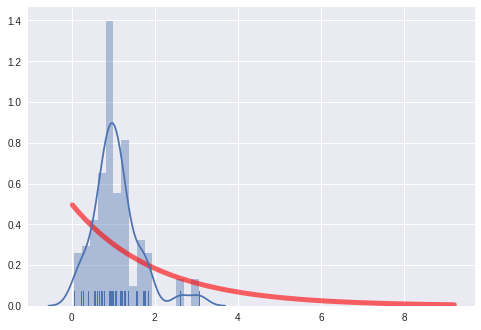

['id', 'k', 'dimension', 'a', 'b', 'distance', 'Percentage distance', 'outliers']
There seems to be no outliers in this cluster


In [25]:
df_with_dists = results.select_prototypes(df_results)

There appear to be no outliers in the data, when using the [$\chi²$-distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution).

In [56]:
df_with_dists.limit(5).toPandas()

,id,k,dimension,a,b,features,casted_features,scaled_features,prediction,centers,distance,Percentage distance,outliers
0,7,4,2,-10.944775,0.206746,"[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]",1,"[-8.07558053467, 1.29785598614]",3.069657,100.000000,0
1,1,4,2,-10.944775,0.206746,"[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]",1,"[-8.07558053467, 1.29785598614]",3.069657,100.000000,0
2,18,4,2,-10.944775,0.206746,"[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]",1,"[-8.07558053467, 1.29785598614]",3.069657,100.000000,0
3,14,4,2,-10.944775,0.206746,"[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]","[-10.9447748047, 0.206746016776]",1,"[-8.07558053467, 1.29785598614]",3.069657,100.000000,0
4,90,2,2,-5.984410,2.866633,"[-5.98441021723, 2.86663304654]","[-5.98441021723, 2.86663304654]","[-5.98441021723, 2.86663304654]",1,"[-8.07558053467, 1.29785598614]",2.614203,99.995445,0


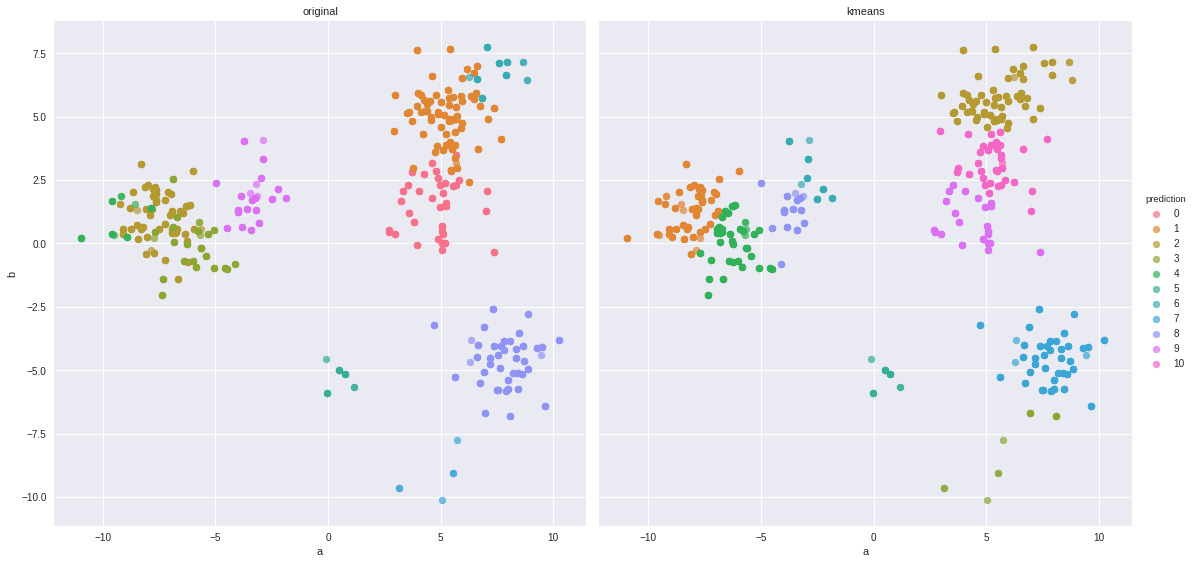

In [88]:
from shared import Plot2DGraphs
from pyspark.sql import functions as F

if test_params_1['algorithm'] == 'GaussianMixture':
    Plot2DGraphs.plot_gaussians(
        df_results,
        execution_model.features,
        gaussian_std=2.5)
else:
    pdf_with_dists = df_with_dists.toPandas()
    pdf_original = (dataIO.data_frame
                    .withColumn('k', F.col('k').cast('integer'))
                    .toPandas())
    
    pdf_with_dists.loc[:,'origin'] = 'kmeans'
    pdf_original.loc[:,'origin'] = 'original'
    pdf_original['prediction'] = pdf_original['k']
    pdf_merged = pd.concat([pdf_original, pdf_with_dists])
    g = sb.FacetGrid(pdf_merged,col="origin", hue="prediction",size=8)
    g.map(plt.scatter, "a", "b", alpha=.7)
    g.add_legend();
    g.set_titles(template='{col_name}')
    plt.show()   

It appears that K-means creates clusters that resembel the input data eg cluster 6 and cluster 7.


Gaussian Mixture Model example
================

The following example shows the results for the Gaussian Mixture model in Apache Spark on our synthetic generated dataset, containing 10 multivariate normal distributions in 2D.

In [94]:
df_with_dists = results.select_prototypes(df_results)

,prediction,Count,Outlier Count
0,1,284,0
1,2,14,0
2,3,271,0
3,4,29,0
4,5,168,0
5,6,14,0
6,7,151,0
7,8,69,0


,prediction,count
0,1,78
1,6,6
2,3,69
3,5,44
4,4,8
5,8,21
6,7,41
7,2,5


Again it appears that we have no outliers for the $\chi²$-distribution; Lets take a look at the plot of our Gaussian Mixture Model with $\mu$ and $\sigma$.

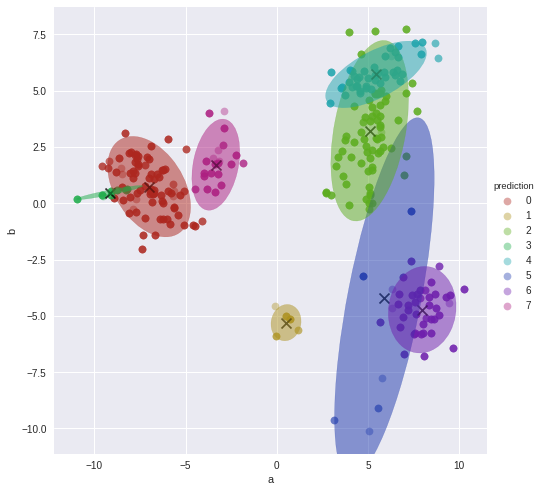

In [97]:
if test_params_1['algorithm'] == 'GaussianMixture':
    Plot2DGraphs.plot_gaussians(
        df_results,
        execution_model.features,
        gaussian_std=2)
else:
    pdf_with_dists = df_with_dists.toPandas()
    pdf_original = (dataIO.data_frame
                    .withColumn('k', F.col('k').cast('integer'))
                    .toPandas())
    
    pdf_with_dists.loc[:,'origin'] = 'kmeans'
    pdf_original.loc[:,'origin'] = 'original'
    pdf_original['prediction'] = pdf_original['k']
    pdf_merged = pd.concat([pdf_original, pdf_with_dists])
    g = sb.FacetGrid(pdf_merged,col="origin", hue="prediction",size=8)
    g.map(plt.scatter, "a", "b", alpha=.7)
    g.add_legend();
    g.set_titles(template='{col_name}')
    plt.show() 

$\mu$ is indicated with *x* and each eplisis indicates the covariance matrix. It appears that there are some outliers contained in each cluster for $2\sigma$. 